### Reference

* https://github.com/MAZiqing/FEDformer
* https://github.com/stitsyuk/xPatch/tree/main/ablation/FEDformer-master

### Import Library

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from math import sqrt
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from models.FEDformer import Model

### Data Directory

In [13]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [14]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [15]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

### FED-former

In [94]:
from layers.Embed import DataEmbedding, DataEmbedding_wo_pos
from layers.AutoCorrelation import AutoCorrelation, AutoCorrelationLayer
from layers.FourierCorrelation import FourierBlock, FourierCrossAttention
from layers.MultiWaveletCorrelation import MultiWaveletCross, MultiWaveletTransform
from layers.SelfAttention_Family import FullAttention, ProbAttention
from layers.Autoformer_EncDec import Encoder, Decoder, EncoderLayer, DecoderLayer, my_Layernorm, series_decomp, series_decomp_multi

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model(nn.Module):
    """
    FEDformer performs the attention mechanism on frequency domain and achieved O(N) complexity
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.version = configs.version
        self.mode_select = configs.mode_select
        self.modes = configs.modes
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Decomp
        kernel_size = configs.moving_avg
        self.decomp = series_decomp(kernel_size)
        
        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        self.enc_embedding = DataEmbedding_wo_pos(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)
        self.dec_embedding = DataEmbedding_wo_pos(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)

        if configs.version == 'Wavelets':
            encoder_self_att = MultiWaveletTransform(ich=configs.d_model, L=configs.L, base=configs.base)
            decoder_self_att = MultiWaveletTransform(ich=configs.d_model, L=configs.L, base=configs.base)
            decoder_cross_att = MultiWaveletCross(in_channels=configs.d_model,
                                                  out_channels=configs.d_model,
                                                  seq_len_q=self.seq_len // 2 + self.pred_len,
                                                  seq_len_kv=self.seq_len,
                                                  modes=configs.modes,
                                                  ich=configs.d_model,
                                                  base=configs.base,
                                                  activation=configs.cross_activation)
        else:
            encoder_self_att = FourierBlock(in_channels=configs.d_model,
                                            out_channels=configs.d_model,
                                            seq_len=self.seq_len,
                                            modes=configs.modes,
                                            mode_select_method=configs.mode_select)
            decoder_self_att = FourierBlock(in_channels=configs.d_model,
                                            out_channels=configs.d_model,
                                            seq_len=self.seq_len//2+self.pred_len,
                                            modes=configs.modes,
                                            mode_select_method=configs.mode_select)
            decoder_cross_att = FourierCrossAttention(in_channels=configs.d_model,
                                                      out_channels=configs.d_model,
                                                      seq_len_q=self.seq_len//2+self.pred_len,
                                                      seq_len_kv=self.seq_len,
                                                      modes=configs.modes,
                                                      mode_select_method=configs.mode_select)
        # Encoder
        enc_modes = int(min(configs.modes, configs.seq_len//2))
        dec_modes = int(min(configs.modes, (configs.seq_len//2+configs.pred_len)//2))
        print('enc_modes: {}, dec_modes: {}'.format(enc_modes, dec_modes))

        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        encoder_self_att,
                        configs.d_model, configs.n_heads),

                    configs.d_model,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        decoder_self_att,
                        configs.d_model, configs.n_heads),
                    AutoCorrelationLayer(
                        decoder_cross_att,
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.c_out,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]]).to(device)  # cuda()
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = F.pad(seasonal_init[:, -self.label_len:, :], (0, 0, 0, self.pred_len))
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]

### Tools for predict

In [95]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_[[date]+target], test_df_[[date]+target], mean_dict, std_dict

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [96]:
from datetime import timedelta
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='m'):
    dates['year'] = dates.date.apply(lambda x: x.year)
    dates['month'] = dates.date.apply(lambda row:row.month) # ,1)
    dates['day'] = dates.date.apply(lambda row:row.day) # ,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday()) # ,1)
    dates['hour'] = dates.date.apply(lambda row:row.hour) # ,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute) # ,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m': ['year', 'month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta >= timedelta(days=28):  # 데이터가 월별로 제공된다고 가정
            self.freq = 'm'
        else:
            self.freq = 'd'  # 기본값을 일별로 설정
        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

### Common Experiment Setting

In [97]:
window_size = 3
forecast_size= 3 
label_len = window_size//2
pred_len = forecast_size

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [101]:
### Experiment Setting
version = "V1"
batch_size = 16
epoch_ = 500
lr = 0.001
# lr = 0.0005
patience = 100  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()

class Configs(object):
    ab = 0
    modes = 32
    mode_select = 'random'
    # version = 'Fourier'
    version = 'Wavelets'
    moving_avg = 12
    L = 1
    base = 'legendre'
    cross_activation = 'tanh'
    seq_len = window_size              # 입력 시퀀스 길이 (96)
    label_len = window_size//2            # 디코더 입력에서 계절성(label) 부분 길이 (일반적으로 seq_len//2)
    pred_len = forecast_size           # 예측 길이 (96)
    output_attention = True
    enc_in = len(columns_to_use)       # 입력 채널 수
    dec_in = len(columns_to_use)       # 입력 채널 수
    d_model = 16
    embed = 'timeF'
    dropout = 0.05
    freq = 'w'
    factor = 1
    n_heads = 8
    d_ff = 16
    e_layers = 2
    d_layers = 1
    c_out = len(columns_to_use)       # 입력 채널 수
    activation = 'gelu'
    wavelet = 0

configs = Configs()

In [102]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)


# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Model(configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)


base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 1, dec_modes: 2


  0%|          | 0/500 [00:00<?, ?it/s]

 29%|██▊       | 143/500 [1:05:48<2:44:17, 27.61s/it]

Early stopping triggered.


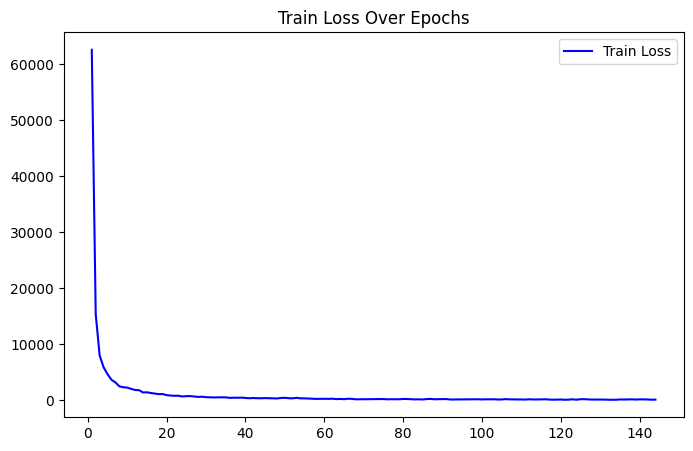

In [107]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float() 
        batch_y_mark = batch_y_mark.float() 
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        
        """
        모델 입력: x_enc, x_mark_enc, x_dec, x_mark_dec
            x_enc: [batch_size, seq_len, enc_in] 
            x_mark_enc: [batch_size, seq_len, mark_dim] 
            x_dec: [batch_size, seq_len//2 + pred_len, dec_in] 
            x_mark_dec: [batch_size, seq_len//2 + pred_len, mark_dim] 
        모델 출력: dec_out 
            [batch_size, pred_len, c_out]
        """
        
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if isinstance(output, tuple):
            output = output[0]
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./FED-former{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)


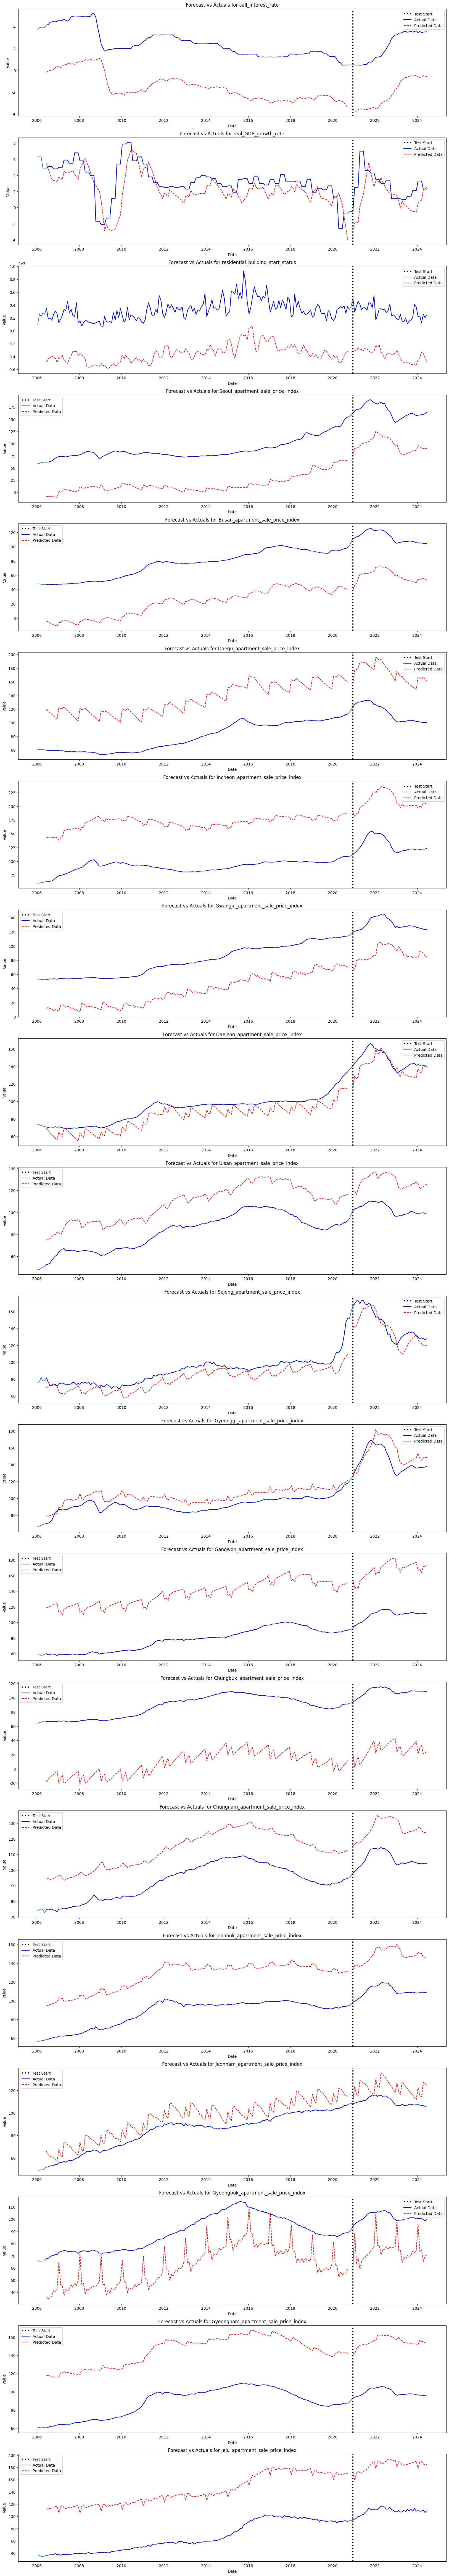

In [111]:
# Load model and Evaluate
model.load_state_dict(torch.load(f"./FED-former{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        if isinstance(output, tuple):
            output = output[0]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        if isinstance(output, tuple):
            output = output[0]
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)


### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [115]:
### Experiment Setting
version = "V3"
batch_size = 16
epoch_ = 500
lr = 0.001
patience = 100  # easrly stopping

columns_to_use = nf.columns.tolist()

class Configs(object):
    ab = 0
    modes = 32
    mode_select = 'random'
    # version = 'Fourier'
    version = 'Wavelets'
    moving_avg = 12
    L = 1
    base = 'legendre'
    cross_activation = 'tanh'
    seq_len = window_size              # 입력 시퀀스 길이 (96)
    label_len = window_size//2            # 디코더 입력에서 계절성(label) 부분 길이 (일반적으로 seq_len//2)
    pred_len = forecast_size           # 예측 길이 (96)
    output_attention = True
    enc_in = len(columns_to_use)       # 입력 채널 수
    dec_in = len(columns_to_use)       # 입력 채널 수
    d_model = 16
    embed = 'timeF'
    dropout = 0.05
    freq = 'w'
    factor = 1
    n_heads = 8
    d_ff = 16
    e_layers = 2
    d_layers = 1
    c_out = len(columns_to_use)       # 입력 채널 수
    activation = 'gelu'
    wavelet = 0

configs = Configs()

In [116]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)


# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Model(configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)


base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 1, dec_modes: 2


 31%|███       | 153/500 [1:43:53<3:55:36, 40.74s/it]  

Early stopping triggered.


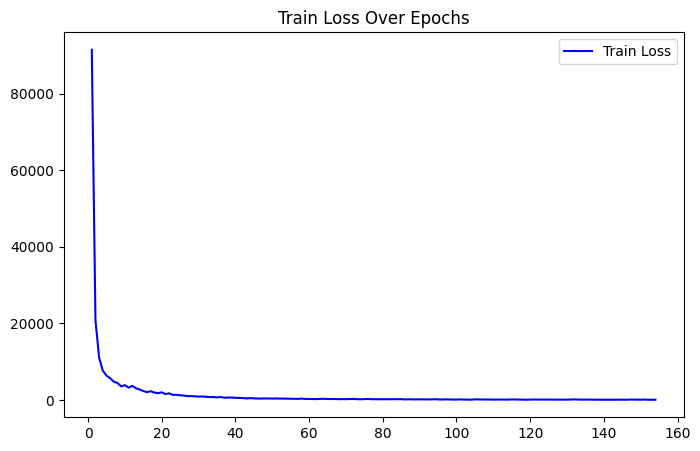

In [117]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float() 
        batch_y_mark = batch_y_mark.float() 
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        
        """
        모델 입력: x_enc, x_mark_enc, x_dec, x_mark_dec
            x_enc: [batch_size, seq_len, enc_in] 
            x_mark_enc: [batch_size, seq_len, mark_dim] 
            x_dec: [batch_size, seq_len//2 + pred_len, dec_in] 
            x_mark_dec: [batch_size, seq_len//2 + pred_len, mark_dim] 
        모델 출력: dec_out 
            [batch_size, pred_len, c_out]
        """
        
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if isinstance(output, tuple):
            output = output[0]
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./FED-former{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_91965/2720277651.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)


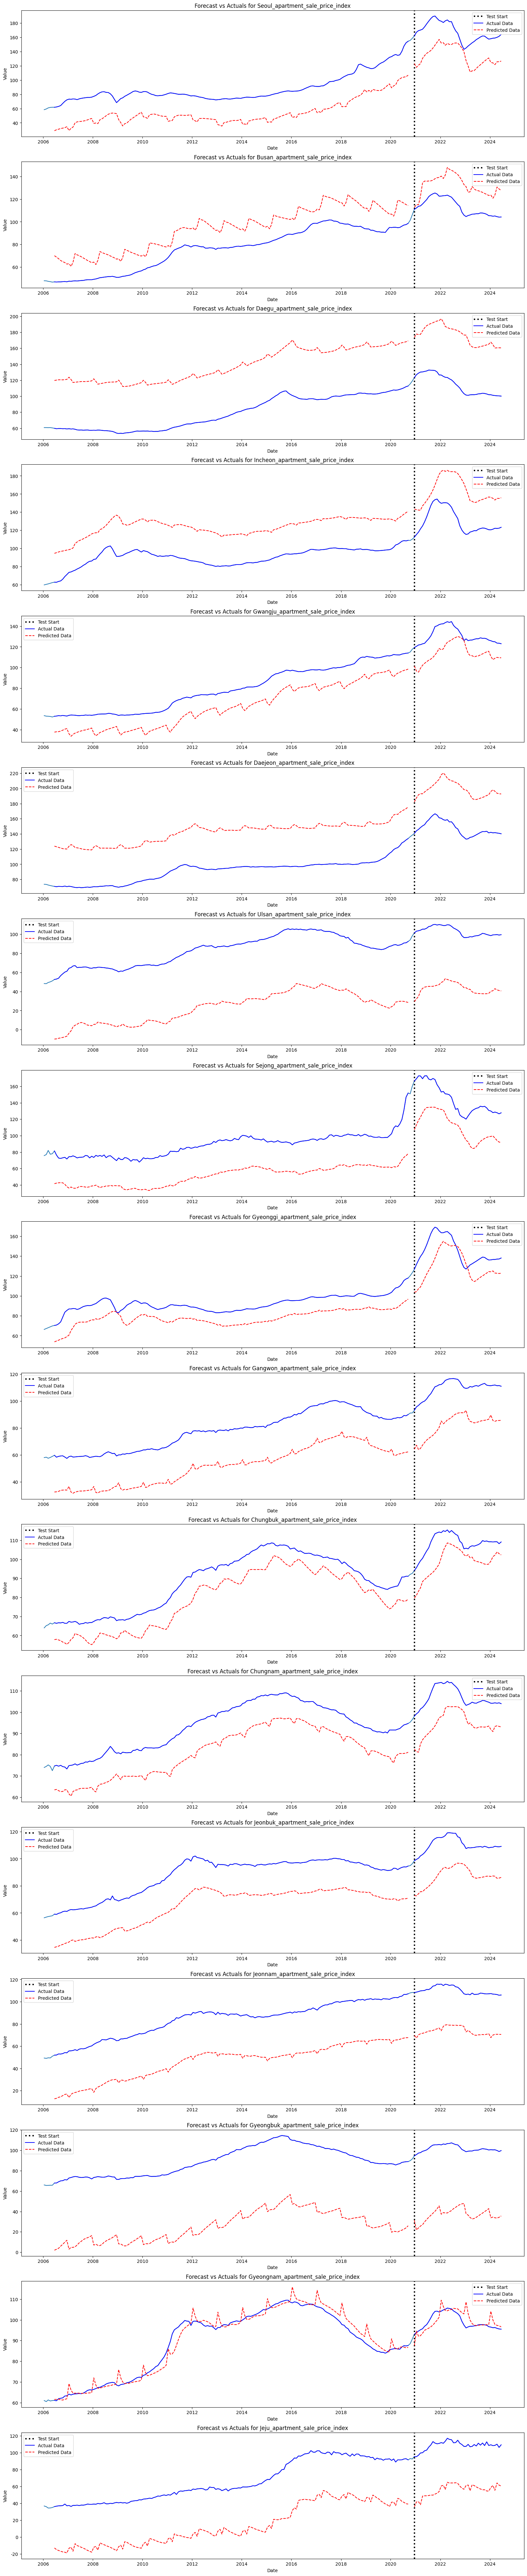

In [118]:
# Load model and Evaluate
model.load_state_dict(torch.load(f"./FED-former{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , label_len, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        if isinstance(output, tuple):
            output = output[0]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        if isinstance(output, tuple):
            output = output[0]
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
